In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os

In [3]:
base_dir = "/content/drive/MyDrive/WR"
data_dir = base_dir + "/WR Finder.v1i.yolov8"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir + "/test"

In [4]:
modes = {"train": train_dir, "val": val_dir, "test": test_dir}

In [5]:
def collect_data(mode):
  imgs = []
  labels = []
  path = modes[mode]
  img_path = os.path.join(path, "images")
  label_path = os.path.join(path, "labels")
  for fn in os.listdir(img_path):
    label_fn = fn[:-3] + "txt"
    img = cv2.imread(os.path.join(img_path, fn))
    with open(os.path.join(label_path, label_fn), "r") as f:
      label = f.readlines()
    imgs.append(img)
    labels.append([box.strip() for box in label])
  return imgs, labels

In [6]:
# filter out NFL logos and end zone coloring, trying to turn the image as green as possible
def filter_football_field(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_green = np.array([40, 40, 40])
    upper_green = np.array([70, 255, 255])

    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours of green areas
    contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the football field by filling the contour areas
    field_mask = np.zeros_like(mask_green)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 5000:
            cv2.drawContours(field_mask, [contour], -1, 255, -1)

    # Invert the field mask
    field_mask = cv2.bitwise_not(field_mask)

    # Create a green background
    green_background = np.zeros_like(image, np.uint8)
    green_background[:] = (0, 255, 0)  # Green color

    # Apply the mask to the original image, and add green background to the filtered image
    filtered_image = cv2.bitwise_and(image, image, mask=field_mask)
    result = cv2.bitwise_or(filtered_image, green_background, mask=field_mask)

    return result

In [7]:
imgs, labels = collect_data("train")

In [8]:
height, width, channels = imgs[0].shape

### YOLO

In [ ]:
# Load YOLO
net = cv2.dnn.readNet(base_dir + "/yolo/yolov3.weights", base_dir + "/yolo/yolov3.cfg")
classes = []
with open(base_dir + "/yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [ ]:
for index in range(20):
  image = imgs[index].copy()

  blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  class_ids = []
  confidences = []
  boxes = []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.3 and class_id == 0:  # Assuming class_id 0 is for person
              # Object detected as person
              center_x = int(detection[0] * width)
              center_y = int(detection[1] * height)
              w = int(detection[2] * width)
              h = int(detection[3] * height)

              # Rectangle coordinates
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)

              boxes.append([x, y, w, h])
              confidences.append(float(confidence))
              class_ids.append(class_id)

  # Non-max suppression to remove overlapping bounding boxes
  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  # Draw bounding boxes
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
      if i in indexes:
          x, y, w, h = boxes[i]
          label = str(classes[class_ids[i]])
          cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
          cv2.putText(image, label, (x, y + 30), font, 2, (0, 255, 0), 2)

  # Display result
  cv2_imshow(image)

### Color Matching

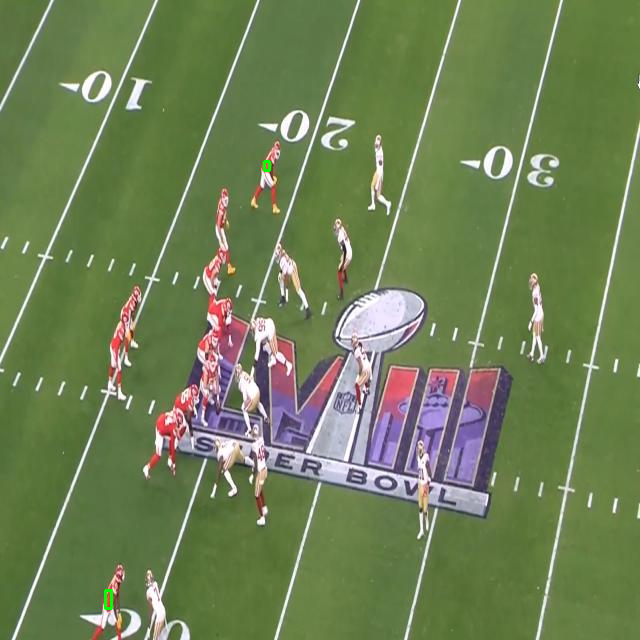

In [14]:
import cv2
import numpy as np

# Load the image
image = imgs[4].copy()

# Convert the image to CIELAB color space
lab_image = cv2.cvtColor(image.astype(np.float32)/255.0, cv2.COLOR_BGR2LAB)

# scarlet_lab = (50, 50, 50)
gold_lab = (77, 10, 20)
red_lab = (53, 63, 36)

# Compute distances from scarlet and gold colors for each pixel
# scarlet_distance = np.linalg.norm(lab_image - np.array(scarlet_lab), axis=2)
gold_distance = np.linalg.norm(lab_image - np.array(gold_lab), axis=2)
red_distance = np.linalg.norm(lab_image - np.array(red_lab), axis=2)


# Combine distances into one metric
# combined_distance = np.sqrt(scarlet_distance**2 + gold_distance**2)

# Threshold to find potential player regions
threshold = 11  # Adjust as needed
potential_sf_players = gold_distance < threshold
potential_kc_players = red_distance < threshold

# # Find contours of potential player regions
sf_contours, _ = cv2.findContours(potential_sf_players.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
kc_contours, _ = cv2.findContours(potential_kc_players.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

sf_boxes = []
kc_boxes = []

# # Draw bounding boxes around potential players
for contour in sf_contours:
    area = cv2.contourArea(contour)

    # Ignore contours that are too small
    if area < 10:  # Adjust the threshold as needed
        continue
    x, y, w, h = cv2.boundingRect(contour)
    # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    sf_boxes.append((x, y, w, h))

for contour in kc_contours:
    area = cv2.contourArea(contour)

    # Ignore contours that are too small
    if area < 10:  # Adjust the threshold as needed
        continue
    x, y, w, h = cv2.boundingRect(contour)
    # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    kc_boxes.append((x, y, w, h))

sf_boxes = sorted(sf_boxes, key=lambda x:x[0])
kc_boxes = sorted(kc_boxes, key=lambda x:x[0])

sf_range = sf_boxes[-1][0] - sf_boxes[0][0]
kc_range = kc_boxes[-1][0] - kc_boxes[0][0]

offense = sf_boxes if sf_range < kc_range else kc_boxes
offense = sorted(offense, key=lambda x:x[1] + x[3])
for x, y, w, h in [offense[0], offense[-1]]:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
# # Display result
cv2_imshow(image)